In [1]:
# sample.py
import ctypes
import os
import threading
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import math
import concurrent.futures

# Running model as a subprocess

In [2]:
# Try to locate the .so file in the same directory as this file
_file = 'libeemodel.dylib'
_path = os.path.join(*(os.path.split(_file)[:-1] + (_file,)))
_mod = ctypes.cdll.LoadLibrary(_path)

In [ ]:
print(_mod)

In [3]:
# parameters for the model
args = [b'0', b'NEW', b'/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Source/Examples/EEModel/eemodel.model']
args_C = (ctypes.c_char_p * len(args))()
args_C[:] = args
#alternative for setting args_C (not tested)
#args_C = (ctypes.c_char_p * len(args))(*args)
#and could use create_string_buffer("string") to create array of strings

In [4]:
_mod.init_model.restype = ctypes.c_void_p
_mod.init_model.argtypes = [ctypes.c_int , ctypes.POINTER(ctypes.c_char_p)]
_mod.run_model.restype = ctypes.c_int
_mod.run_model.argtypes = [ctypes.c_void_p]

In [5]:
#initializing model and getting ui pointer from initialization
res = _mod.init_model(len(args_C), args_C)

In [ ]:
print(res)

In [ ]:
#running model after it is initialized
res2 = _mod.run_model(res)

In [6]:
#wrapper function to run model to be used in concurrent
def run_model(res):
#    res = _mod.run_model_test( len(args_C_), args_C_)
    _mod.run_model(res)

In [7]:
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    future = executor.submit(run_model, res)
#alternative that does not work is with threads
#t1 = threading.Thread(target=_mod.run_model, args = [res])
#t1.start()    
#t1.join()

# Initialization parameters - visuals

## graph for expected time before next maintenance

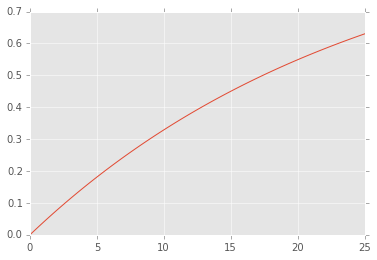

In [10]:
lambda_ = 2500
alpha = 100
y = np.zeros(100)
x = np.zeros(100)
i = 0


for step in np.linspace(0.01, 25, num=100):
    x[i] = step
#    y[i] = lambda_ * math.pow((1 - x[i]), -(1/alpha)) - 1
    #cdf
    y[i] = 1 - math.pow(1 + x[i]/lambda_, - alpha)
    i = i + 1
#draw graph
plt.plot(x, y)

## Graph for expected share of sales

4.0
0.0833333333333


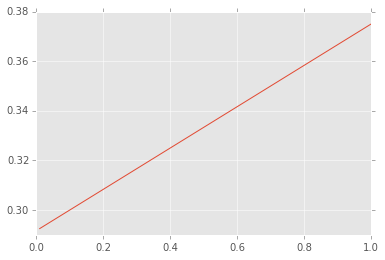

In [28]:
theta = np.array([1.0, 1.0, 1.0, 1.0, 1.0])

irr_i = 0.5
rep = 1
rep_i = 1
irr = irr_i
X = np.array([1, irr, rep, irr_i, rep_i])


#split market equally given number of agents
N = 3

sum = np.dot(X, theta)
print(sum)

scale_factor = 1/sum/N
print (scale_factor)

theta = theta * scale_factor


y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 1, num=100):
    x[i] = step
    X[1] = x[i]
    y[i] = np.dot(X, theta)
    i = i + 1
#draw graph
plt.plot(x, y)


4.5
0.0740740740741
